In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
#import xgboost as xgb

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

In [2]:
data = pd.read_csv('./insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### There are no missing values as such

In [4]:
data['region'].value_counts().sort_values()

northeast    324
southwest    325
northwest    325
southeast    364
Name: region, dtype: int64

In [5]:
data['children'].value_counts().sort_values()

5     18
4     25
3    157
2    240
1    324
0    574
Name: children, dtype: int64

### Converting Categorical Features to Numerical

In [6]:
clean_data = {'sex': {'male' : 0 , 'female' : 1} ,
                 'smoker': {'no': 0 , 'yes' : 1},
                   'region' : {'northwest':0, 'northeast':1,'southeast':2,'southwest':3}
               }
data_copy = data.copy()
data_copy.replace(clean_data, inplace=True)

In [7]:
data_copy.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,30.663397,1.094918,0.204783,1.514948,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.105572,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,0.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


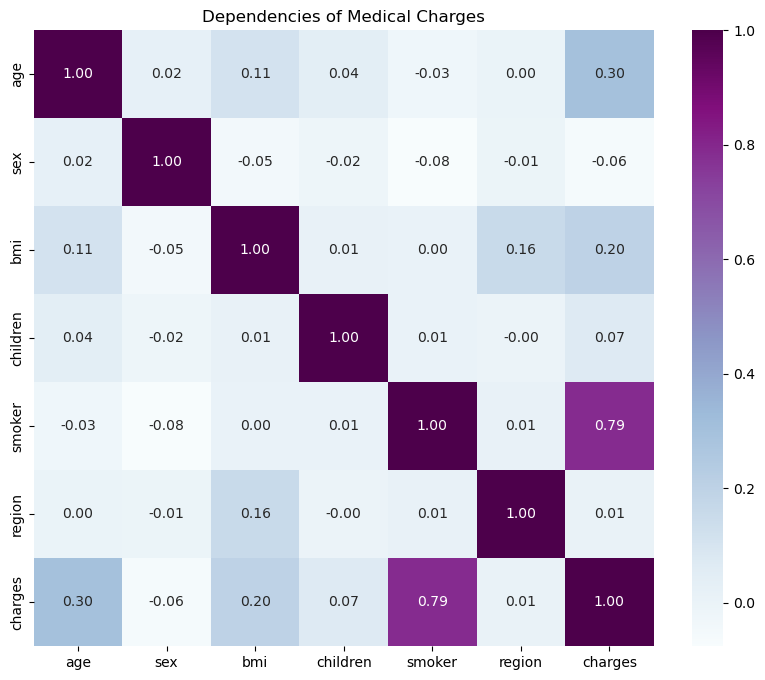

In [9]:
corr = data_copy.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr,cmap='BuPu',annot=True,fmt=".2f",ax=ax)
plt.title("Dependencies of Medical Charges")
#plt.savefig('./sampleImages/Cor')
plt.show()

### Smoker, BMI and Age are most important factor that determnines - Charges
Also we see that Sex, Children and Region do not affect the Charges.
We might drop these 3 columns as they have less correlation

In [11]:
print(data['sex'].value_counts().sort_values()) 
print(data['smoker'].value_counts().sort_values())
print(data['region'].value_counts().sort_values())

female    662
male      676
Name: sex, dtype: int64
yes     274
no     1064
Name: smoker, dtype: int64
northeast    324
southwest    325
northwest    325
southeast    364
Name: region, dtype: int64


### Now we are confirmed that there are no other values in above pre-preocessed column, We can proceed with EDA

<AxesSubplot:title={'center':'Age vs Charge'}, xlabel='age', ylabel='charges'>

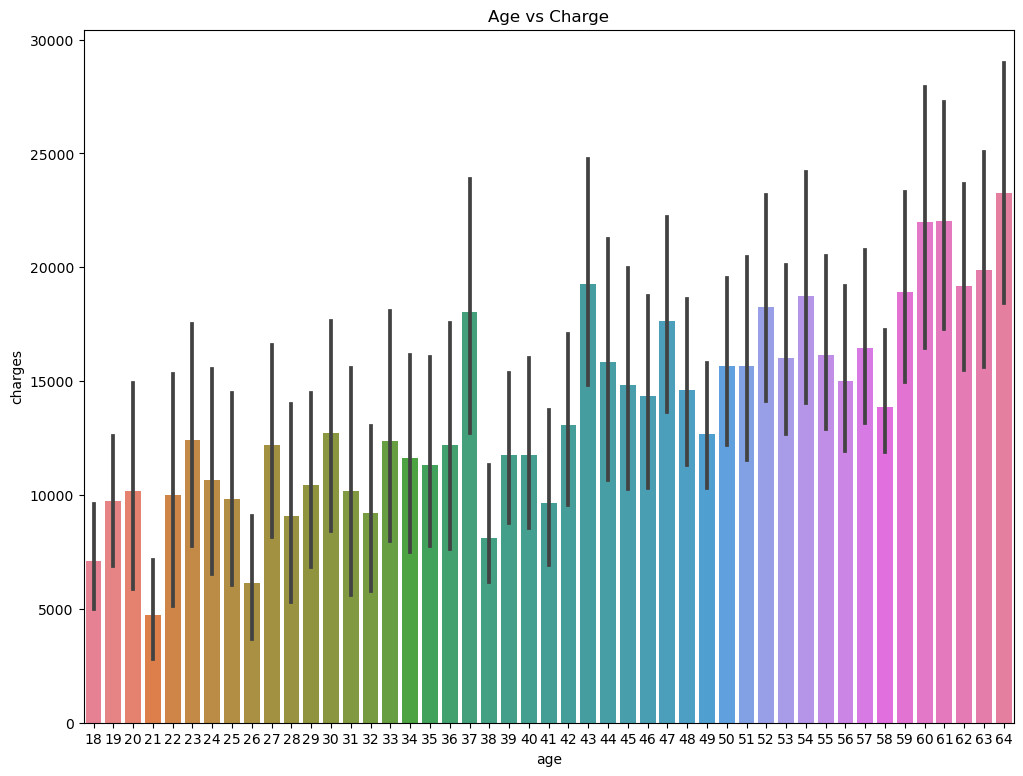

In [13]:
plt.figure(figsize=(12,9))
plt.title('Age vs Charge')
sns.barplot(x='age',y='charges',data=data_copy,palette='husl')

<AxesSubplot:title={'center':'Region vs Charge'}, xlabel='region', ylabel='charges'>

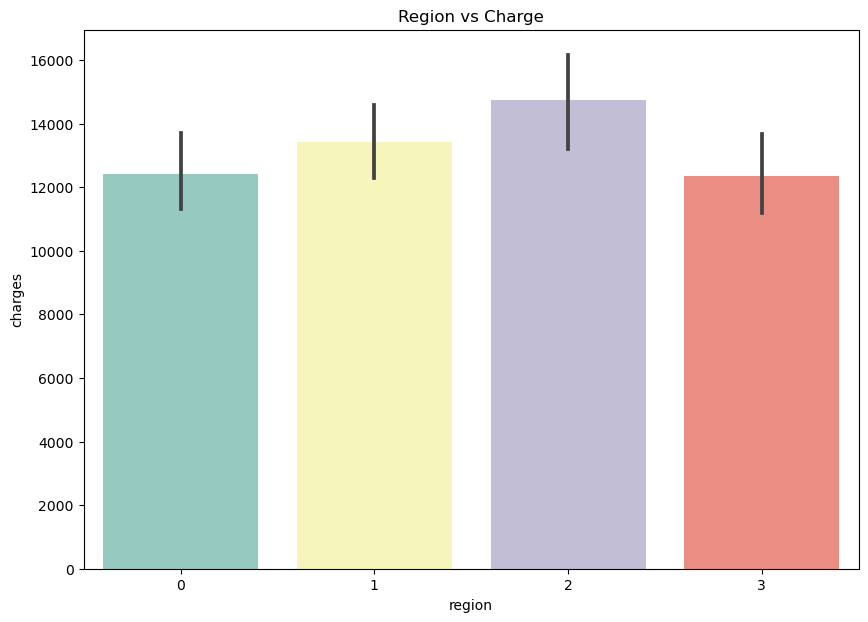

In [14]:
plt.figure(figsize=(10,7))
plt.title('Region vs Charge')
sns.barplot(x='region',y='charges',data=data_copy,palette='Set3')

Text(0.5, 1.0, 'BMI VS Charge')

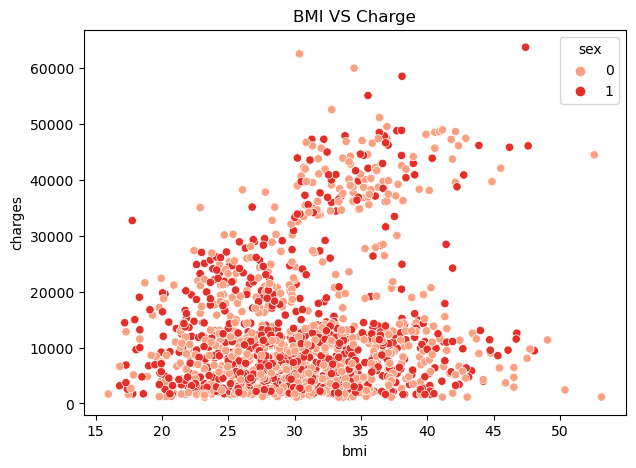

In [15]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='bmi',y='charges',hue='sex',data=data_copy,palette='Reds')
plt.title('BMI VS Charge')

<AxesSubplot:title={'center':'Smoker vs Charge'}, xlabel='smoker', ylabel='charges'>

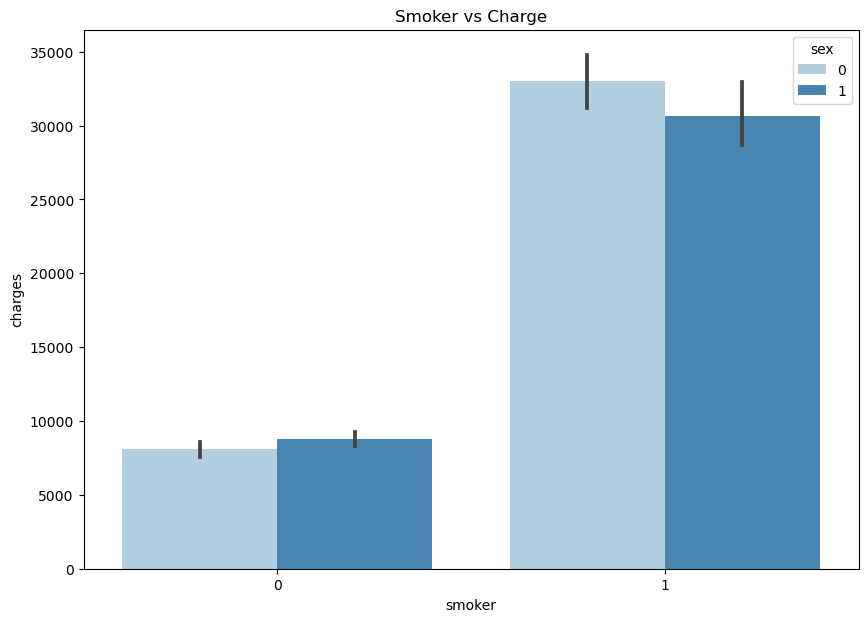

In [16]:
plt.figure(figsize=(10,7))
plt.title('Smoker vs Charge')
sns.barplot(x='smoker',y='charges',data=data_copy,palette='Blues',hue='sex')

<AxesSubplot:title={'center':'Sex vs Charges'}, xlabel='sex', ylabel='charges'>

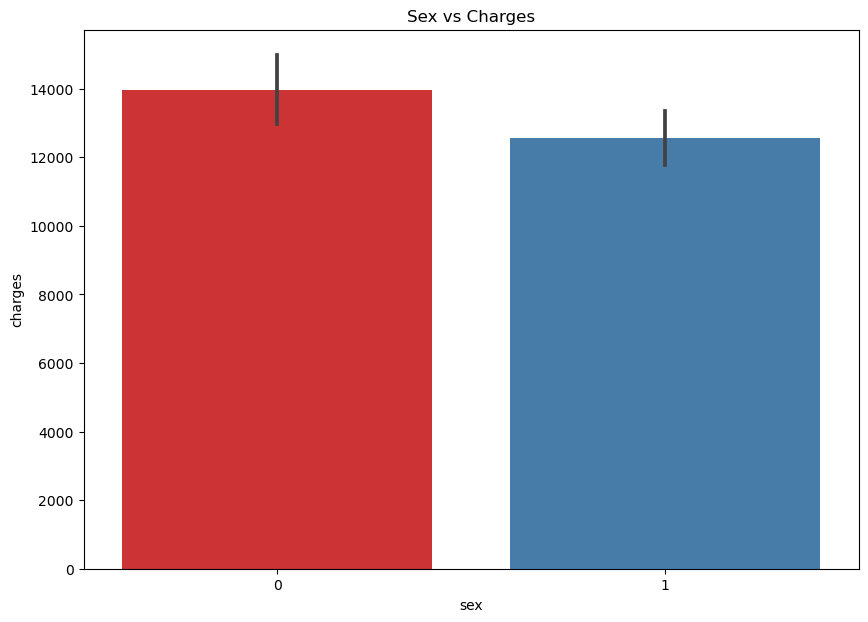

In [17]:
plt.figure(figsize=(10,7))
plt.title('Sex vs Charges')
sns.barplot(x='sex',y='charges',data=data_copy,palette='Set1')

### Plotting Skew and Kurtosis

In [18]:
print('Printing Skewness and Kurtosis for all columns')
print()
for col in list(data_copy.columns):
    print('{0} : Skewness {1:.3f} and  Kurtosis {2:.3f}'.format(col,data_copy[col].skew(),data_copy[col].kurt()))

Printing Skewness and Kurtosis for all columns

age : Skewness 0.056 and  Kurtosis -1.245
sex : Skewness 0.021 and  Kurtosis -2.003
bmi : Skewness 0.284 and  Kurtosis -0.051
children : Skewness 0.938 and  Kurtosis 0.202
smoker : Skewness 1.465 and  Kurtosis 0.146
region : Skewness -0.038 and  Kurtosis -1.329
charges : Skewness 1.516 and  Kurtosis 1.606


Text(0, 0.5, 'Count')

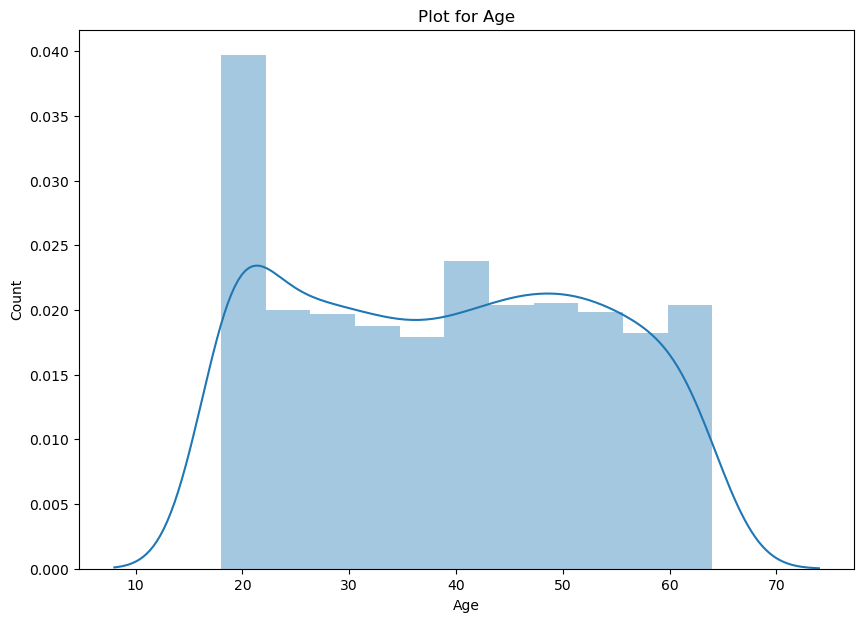

In [27]:
plt.figure(figsize=(10,7))
sns.distplot(data_copy['age'])
plt.title('Plot for Age')
plt.xlabel('Age')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

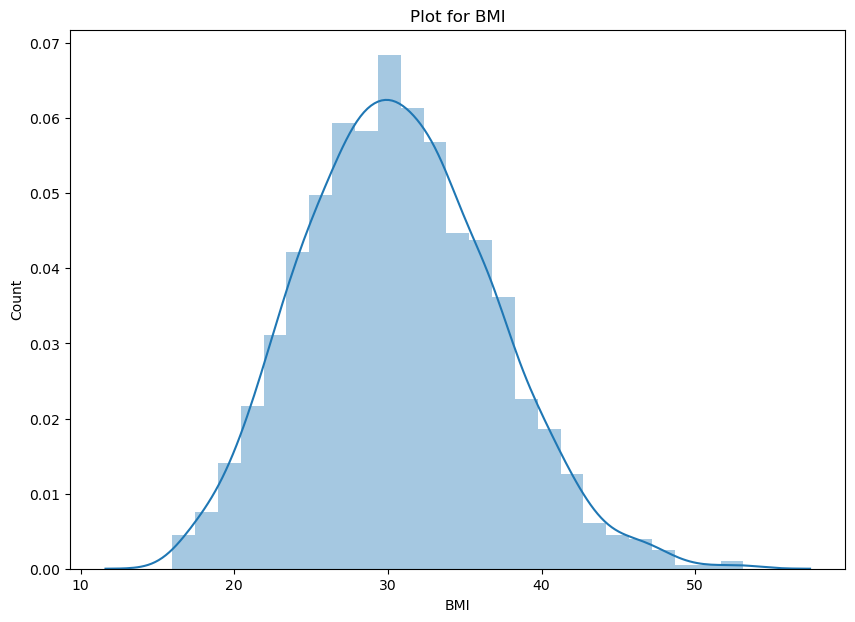

In [28]:
plt.figure(figsize=(10,7))
sns.distplot(data_copy['bmi'])
plt.title('Plot for BMI')
plt.xlabel('BMI')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

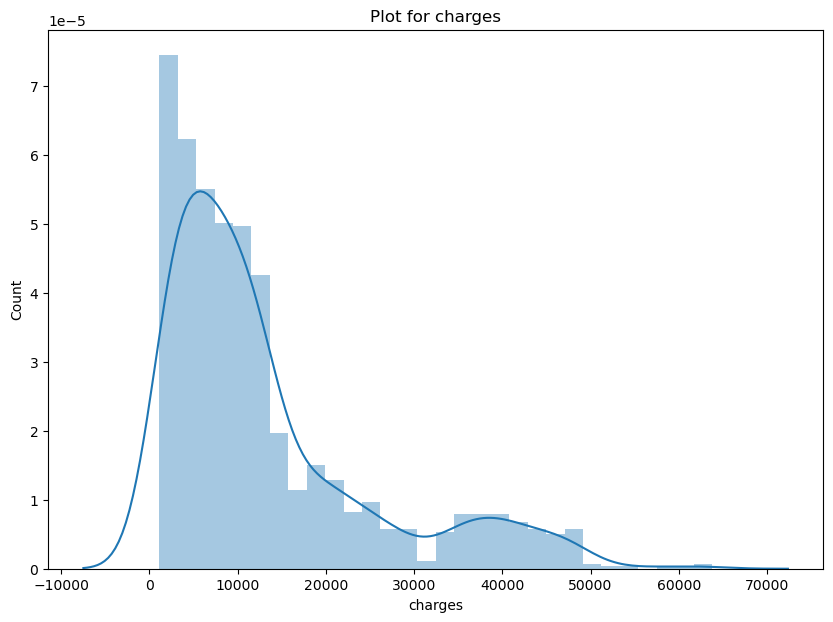

In [29]:
plt.figure(figsize=(10,7))
sns.distplot(data_copy['charges'])
plt.title('Plot for charges')
plt.xlabel('charges')
plt.ylabel('Count')

### There might be few outliers in Charges but then we cannot say that the value is an outlier as there might be cases in which Charge for medical was very les actually!

### Prepating data - We can scale BMI and Charges Column before proceeding with Prediction

In [31]:
from sklearn.preprocessing import StandardScaler
data_pre = data_copy.copy()

tempBmi = data_pre.bmi
tempBmi = tempBmi.values.reshape(-1,1)
data_pre['bmi'] = StandardScaler().fit_transform(tempBmi)

tempAge = data_pre.age
tempAge = tempAge.values.reshape(-1,1)
data_pre['age'] = StandardScaler().fit_transform(tempAge)

tempCharges = data_pre.charges
tempCharges = tempCharges.values.reshape(-1,1)
data_pre['charges'] = StandardScaler().fit_transform(tempCharges)

data_pre.head()

,age,sex,bmi,children,smoker,region,charges
0,-1.438764,1,-0.453320,0,1,3,0.298584
1,-1.509965,0,0.509621,1,0,2,-0.953689
2,-0.797954,0,0.383307,3,0,2,-0.728675
3,-0.441948,0,-1.305531,0,0,0,0.719843
4,-0.513149,0,-0.292556,0,0,0,-0.776802


In [32]:
X = data_pre.drop('charges',axis=1).values
y = data_pre['charges'].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

print('Size of X_train : ', X_train.shape)
print('Size of y_train : ', y_train.shape)
print('Size of X_test : ', X_test.shape)
print('Size of Y_test : ', y_test.shape)

Size of X_train :  (1070, 6)
Size of y_train :  (1070, 1)
Size of X_test :  (268, 6)
Size of Y_test :  (268, 1)


## Linear Regression

In [37]:
%%time
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

Wall time: 997 µs


LinearRegression()

In [38]:
cv_linear_reg = cross_val_score(estimator = linear_reg, X = X, y = y, cv = 10)

y_pred_linear_reg_train = linear_reg.predict(X_train)
r2_score_linear_reg_train = r2_score(y_train, y_pred_linear_reg_train)

y_pred_linear_reg_test = linear_reg.predict(X_test)
r2_score_linear_reg_test = r2_score(y_test, y_pred_linear_reg_test)

rmse_linear = (np.sqrt(mean_squared_error(y_test, y_pred_linear_reg_test)))

print('CV Linear Regression : {0:.3f}'.format(cv_linear_reg.mean()))
print('R2_score (train) : {0:.3f}'.format(r2_score_linear_reg_train))
print('R2_score (test) : {0:.3f}'.format(r2_score_linear_reg_test))
print('RMSE : {0:.3f}'.format(rmse_linear))

CV Linear Regression : 0.745
R2_score (train) : 0.741
R2_score (test) : 0.783
RMSE : 0.480


## Support Vector Machine (Regression)

In [39]:
X_c = data_copy.drop('charges',axis=1).values
y_c = data_copy['charges'].values.reshape(-1,1)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c,y_c,test_size=0.2, random_state=42)

X_train_scaled = StandardScaler().fit_transform(X_train_c)
y_train_scaled = StandardScaler().fit_transform(y_train_c)
X_test_scaled = StandardScaler().fit_transform(X_test_c)
y_test_scaled = StandardScaler().fit_transform(y_test_c)

svr = SVR()


In [40]:
parameters =  { 'kernel' : ['rbf', 'sigmoid'],
                 'gamma' : [0.001, 0.01, 0.1, 1, 'scale'],
                 'tol' : [0.0001],
                 'C': [0.001, 0.01, 0.1, 1, 10, 100] }
svr_grid = GridSearchCV(estimator=svr, param_grid=parameters, cv=10, verbose=4, n_jobs=-1)
svr_grid.fit(X_train_scaled, y_train_scaled.ravel())

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
                         'kernel': ['rbf', 'sigmoid'], 'tol': [0.0001]},
             verbose=4)

In [42]:
svr = SVR(C=10, gamma=0.1, tol=0.0001)
svr.fit(X_train_scaled, y_train_scaled.ravel())
print(svr_grid.best_estimator_)
print(svr_grid.best_score_)

SVR(C=10, gamma=0.1, tol=0.0001)
0.8311276912561496


In [43]:
cv_svr = svr_grid.best_score_

y_pred_svr_train = svr.predict(X_train_scaled)
r2_score_svr_train = r2_score(y_train_scaled, y_pred_svr_train)

y_pred_svr_test = svr.predict(X_test_scaled)
r2_score_svr_test = r2_score(y_test_scaled, y_pred_svr_test)

rmse_svr = (np.sqrt(mean_squared_error(y_test_scaled, y_pred_svr_test)))

print('CV : {0:.3f}'.format(cv_svr.mean()))
print('R2_score (train) : {0:.3f}'.format(r2_score_svr_train))
print('R2 score (test) : {0:.3f}'.format(r2_score_svr_test))
print('RMSE : {0:.3f}'.format(rmse_svr))

CV : 0.831
R2_score (train) : 0.857
R2 score (test) : 0.871
RMSE : 0.359


## Ridge Regressor

In [44]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

steps = [ ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('model', Ridge())]

ridge_pipe = Pipeline(steps)

In [45]:
parameters = { 'model__alpha': [1e-15, 1e-10, 1e-8, 1e-3, 1e-2,1,2,5,10,20,25,35, 43,55,100], 'model__random_state' : [42]}
reg_ridge = GridSearchCV(ridge_pipe, parameters, cv=10)
reg_ridge = reg_ridge.fit(X_train, y_train.ravel())

In [46]:
reg_ridge.best_estimator_, reg_ridge.best_score_

(Pipeline(steps=[('scalar', StandardScaler()), ('poly', PolynomialFeatures()),
                 ('model', Ridge(alpha=20, random_state=42))]),
 0.8259990140429396)

In [47]:
ridge = Ridge(alpha=20, random_state=42)
ridge.fit(X_train_scaled, y_train_scaled.ravel())
cv_ridge = reg_ridge.best_score_

y_pred_ridge_train = ridge.predict(X_train_scaled)
r2_score_ridge_train = r2_score(y_train_scaled, y_pred_ridge_train)

y_pred_ridge_test = ridge.predict(X_test_scaled)
r2_score_ridge_test = r2_score(y_test_scaled, y_pred_ridge_test)

rmse_ridge = (np.sqrt(mean_squared_error(y_test_scaled, y_pred_linear_reg_test)))
print('CV : {0:.3f}'.format(cv_ridge.mean()))
print('R2 score (train) : {0:.3f}'.format(r2_score_ridge_train))
print('R2 score (test) : {0:.3f}'.format(r2_score_ridge_test))
print('RMSE : {0:.3f}'.format(rmse_ridge))

CV : 0.826
R2 score (train) : 0.741
R2 score (test) : 0.784
RMSE : 0.465


## RandomForest Regressor

In [48]:
%%time
reg_rf = RandomForestRegressor()
parameters = { 'n_estimators':[600,1000,1200],
             'max_features': ["auto"],
             'max_depth':[40,50,60],
             'min_samples_split': [5,7,9],
             'min_samples_leaf': [7,10,12],
             'criterion': ['mse']}

reg_rf_gscv = GridSearchCV(estimator=reg_rf, param_grid=parameters, cv=10, n_jobs=-1)
reg_rf_gscv = reg_rf_gscv.fit(X_train_scaled, y_train_scaled.ravel())

Wall time: 5min 52s


In [50]:
reg_rf_gscv.best_score_, reg_rf_gscv.best_estimator_

(0.8484905833471561,
 RandomForestRegressor(criterion='mse', max_depth=60, min_samples_leaf=12,
                       min_samples_split=9, n_estimators=600))

In [51]:
rf_reg = RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                       n_estimators=1200)
rf_reg.fit(X_train_scaled, y_train_scaled.ravel())

RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                      n_estimators=1200)

In [52]:
cv_rf = reg_rf_gscv.best_score_

y_pred_rf_train = rf_reg.predict(X_train_scaled)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

y_pred_rf_test = rf_reg.predict(X_test_scaled)
r2_score_rf_test = r2_score(y_test_scaled, y_pred_rf_test)

rmse_rf = np.sqrt(mean_squared_error(y_test_scaled, y_pred_rf_test))

print('CV : {0:.3f}'.format(cv_rf.mean()))
print('R2 score (train) : {0:.3f}'.format(r2_score_rf_train))
print('R2 score (test) : {0:.3f}'.format(r2_score_rf_test))
print('RMSE : {0:.3f}'.format(rmse_rf))

CV : 0.848
R2 score (train) : 0.885
R2 score (test) : 0.879
RMSE : 0.348


In [53]:
models = [('Linear Regression', rmse_linear, r2_score_linear_reg_train, r2_score_linear_reg_test, cv_linear_reg.mean()),
          ('Ridge Regression', rmse_ridge, r2_score_ridge_train, r2_score_ridge_test, cv_ridge.mean()),
          ('Support Vector Regression', rmse_svr, r2_score_svr_train, r2_score_svr_test, cv_svr.mean()),
          ('Random Forest Regression', rmse_rf, r2_score_rf_train, r2_score_rf_test, cv_rf.mean())   
         ]

In [54]:
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

,Model,RMSE,R2_Score(training),R2_Score(test),Cross-Validation
0,Linear Regression,0.479808,0.741410,0.782694,0.744528
1,Ridge Regression,0.465206,0.741150,0.783800,0.825999
2,Support Vector Regression,0.358769,0.857235,0.871285,0.831128
3,Random Forest Regression,0.347898,0.884552,0.878967,0.848491


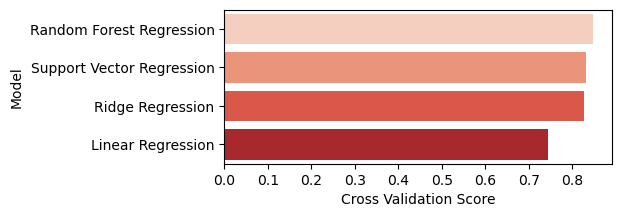

In [60]:
plt.figure(figsize=(5,2))
predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model',data = predict, palette='Reds')
plt.xlabel('Cross Validation Score')
plt.ylabel('Model')
plt.show()

## Training Data without Scaling for RandomClassifier

In [61]:
data_copy.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92400
1,18,0,33.770,1,0,2,1725.55230
2,28,0,33.000,3,0,2,4449.46200
3,33,0,22.705,0,0,0,21984.47061
4,32,0,28.880,0,0,0,3866.85520


In [62]:
X_ = data_copy.drop('charges',axis=1).values
y_ = data_copy['charges'].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_,y_,test_size=0.2, random_state=42)

print('Size of X_train_ : ', X_train_.shape)
print('Size of y_train_ : ', y_train_.shape)
print('Size of X_test_ : ', X_test_.shape)
print('Size of Y_test_ : ', y_test_.shape)

Size of X_train_ :  (1070, 6)
Size of y_train_ :  (1070, 1)
Size of X_test_ :  (268, 6)
Size of Y_test_ :  (268, 1)


In [63]:
rf_reg = RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                       n_estimators=1200)
rf_reg.fit(X_train_, y_train_.ravel())

RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                      n_estimators=1200)

In [64]:
y_pred_rf_train_ = rf_reg.predict(X_train_)
r2_score_rf_train_ = r2_score(y_train_, y_pred_rf_train_)

y_pred_rf_test_ = rf_reg.predict(X_test_)
r2_score_rf_test_ = r2_score(y_test_, y_pred_rf_test_)

print('R2 score (train) : {0:.3f}'.format(r2_score_rf_train_))
print('R2 score (test) : {0:.3f}'.format(r2_score_rf_test_))

R2 score (train) : 0.885
R2 score (test) : 0.878


In [68]:
import pickle

Pkl_Filename = "random_forest.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(rf_reg, file)

In [69]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    rf_tuned_loaded = pickle.load(file)

In [70]:
rf_tuned_loaded

RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                      n_estimators=1200)

In [71]:
pred=rf_tuned_loaded.predict(np.array([20,1,28,0,1,3]).reshape(1,6))[0]

In [72]:
print('{0:.3f}'.format(pred))

19051.282
